## Indoor or Outdoor

In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [10]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install fastai duckduckgo-images-api requests duckduckgo_search

  Obtaining dependency information for duckduckgo_search from https://files.pythonhosted.org/packages/97/8e/01d4aea1f9fdac45973d2f1d07d29832a243f91106e10d8ffb442adf4f4d/duckduckgo_search-4.2-py3-none-any.whl.metadata
  Obtaining dependency information for curl-cffi>=0.5.10 from https://files.pythonhosted.org/packages/93/04/0d57a51690451437f72563031036ea4f4b529bc0cfd8e8d93487075cbe80/curl_cffi-0.5.10-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 61.3 MB/s eta 0:00:00:00:010:01


## Step 1: Download images 

In [19]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        search_results = ddgs.images(keywords=term)       
        image_urls = [next(search_results).get("image") for _ in range(max_images)]
        return L(image_urls)

In [20]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images("indoor images", max_images=10)
urls[0]

Searching for 'indoor images'


'https://decoholic.org/wp-content/uploads/2019/11/73420430_2490214817970138_5932545397536226539_n-720x893.jpg'

Searching for 'indoor photos'


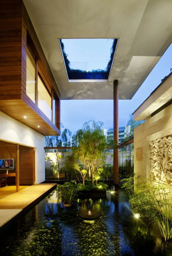

In [28]:
from fastdownload import download_url
from fastai.vision.all import *

download_url(search_images('indoor photos', max_images=1)[0], 'indoor.jpg', show_progress=False)
Image.open('indoor.jpg').to_thumb(256,256)

Searching for 'outdoor photos'


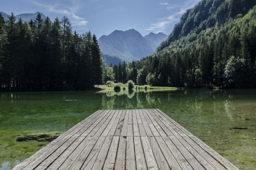

In [24]:
download_url(search_images('outdoor photos', max_images=1)[0], 'outdoor.jpg', show_progress=False)
Image.open('outdoor.jpg').to_thumb(256,256)

In [29]:
searches = 'outdoor','indoor'
path = Path('indoor_or_outdoor')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'outdoor photo'
Searching for 'outdoor sun photo'
Searching for 'outdoor shade photo'
Searching for 'indoor photo'
Searching for 'indoor sun photo'
Searching for 'indoor shade photo'


## Step 2: Train our model

In [30]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

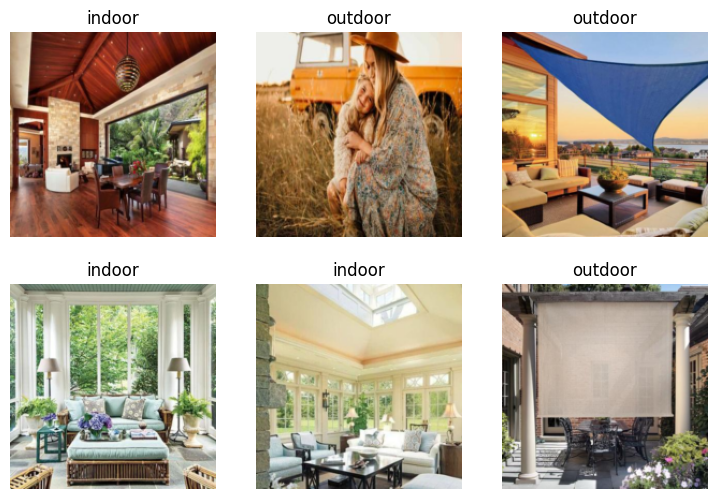

In [31]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [32]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 152MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,1.400159,2.353065,0.500000,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.524324,0.636354,0.323529,00:01
1,0.335727,0.118239,0.029412,00:00
2,0.265864,0.057064,0.029412,00:00


## Step 3: Use our model (and build your own!)

In [33]:
is_indoor,_,probs = learn.predict(PILImage.create('indoor.jpg'))
print(f"This is a: {is_indoor}.")
print(f"Probability it's indoor: {probs[0]:.4f}")

This is a: indoor.
Probability it's indoor: 0.7319
